### install

In [28]:
import sys
print(sys.version)

3.8.2 (default, Mar 26 2020, 10:43:30) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [38]:
print(np.__version__)

1.24.2


In [1]:
pip install cupy-cuda102

ERROR: Could not find a version that satisfies the requirement cupy-cuda102 (from versions: none)
ERROR: No matching distribution found for cupy-cuda102
Note: you may need to restart the kernel to use updated packages.


### Importing

In [9]:
import extcolors
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import cv2
from PIL import Image, ImageFile
import io


2023-02-09 13:50:02.665727: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 배경 제거하기1 - 단일 색상이 있는 배경을 지우는 방법 ( low accuracy )

In [49]:
img = cv2.imread("sports_009.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)[1]

mask = 255 - mask

kernel = np.ones((3,3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

mask = cv2.GaussianBlur(mask, (0,0),  sigmaX=2, sigmaY=2, borderType = cv2.BORDER_DEFAULT)

mask = (2*(mask.astype(np.float32))-255.0).clip(0,255).astype(np.uint8)

result = img.copy()
result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
result[:, :, 3] = mask

cv2.imwrite('sports_new_009.png', result)

True

- input img에서 배경을 제거하고 ->png 로 변경 한후 , img의 주요 색상을 다시 재검출 해보기
- 배경에 여러 색상이 들어가 있는 일반적인 사진에 대한 일반화 성능이 떨어짐 

### 배경 제거하기2 ( Used By Deep Image Matting - reference/examples 이 필요 )

In [50]:
from pymatting import cutout

### 배경 제거하기 3  ( rembg-test )

In [55]:
from rembg.bg import remove

In [77]:
def show_rembg(i_path, o_path):
    # fig = plt.figure(figsize=(10, 10))
    
    # fig.add_subplot(1,2,1)
    orig_img = Image.open(i_path)
    # plt.imshow(orig_img)
    
    output = remove(orig_img)
    # fig.add_subplot(1,2,2)
    # plt.imshow(output)
    output.save(o_path)

In [78]:
def show_rembg2(i_path, o_path):
    fig = plt.figure(figsize=(10, 10))
    
    fig.add_subplot(1,2,1)
    orig_img = Image.open(i_path)
    plt.imshow(orig_img)
    
    output = remove(orig_img)
    fig.add_subplot(1,2,2)
    plt.imshow(output)
    output.save(o_path)
    

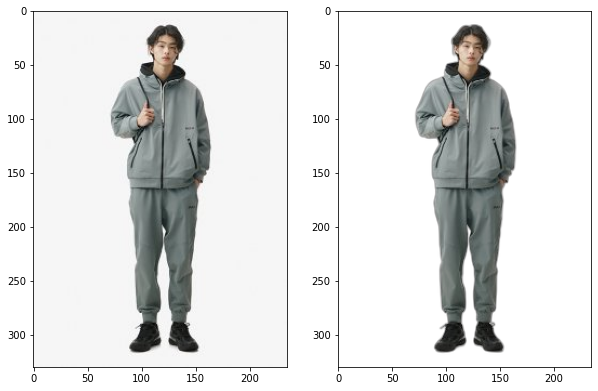

In [79]:
input_path = 'sports_009.jpg'
output_path = 'sports_009_rembg.png'
show_rembg2(input_path, output_path)

### 배경 제거된 이미지의 주요 색상 추출하기

In [67]:
from colorthief import ColorThief
import matplotlib.pyplot as plt
import colorsys

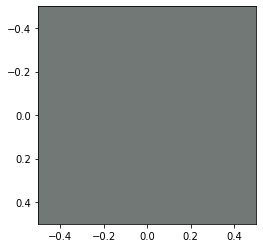

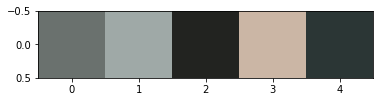

In [68]:
ct = ColorThief("sports_009_rembg.png")
dominant_color = ct.get_color(quality=1)

plt.imshow([[dominant_color]])
plt.show()

palette = ct.get_palette(color_count = 5)
plt.imshow([[palette[i] for i in range(5)]])
plt.show()



### 배경이 제거된 이미지에서 색상 RGB16 코드값을 추출하기

In [69]:
img = Image.open("sports_009_rembg.png")
colors, pixel_count = extcolors.extract_from_image(img)

pixel_output = 0
for c in colors:
    pixel_output += c[1]
    print(f'{c[0]} : {round((c[1] / pixel_count) * 100, 2)} % ({c[1]})')
print(f'Pixels in output : {pixel_output} of {pixel_count}')

(127, 136, 135) : 17.56 % (13614)
(1, 1, 1) : 6.14 % (4759)
(239, 214, 194) : 0.08 % (65)
(85, 64, 47) : 0.02 % (19)
Pixels in output : 18457 of 77550


### Feature Extraction

In [80]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from tqdm import tqdm
from pathlib import Path

In [81]:
class FeatureExtractor:
    def __init__(self):
        base_model = VGG16(weights='imagenet')
        print(base_model.summary())
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

    def extract(self, img):
        img = img.resize((224, 224))
        img = img.convert('RGB')
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)

In [72]:
features = []
img_paths = []
categories = ['americancasual', 'casual', 'dandy', 'formal', 'sports', 'street']

fe = FeatureExtractor()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [95]:
for i in range(len(categories)):
    print("Category : " , categories[i])
    for j in range(2, 62):
        try:
            image_path = "./fashion_dataset/" + categories[i] + "/" + categories[i] +  "_" + str(j).zfill(3) + ".jpg"
            output_path = "./fs_dataset_rembg/" + categories[i] + "/" + categories[i] +  "_" + str(j).zfill(3) + "_rembg.png"
            show_rembg(image_path, output_path)
            
            img_paths.append(output_path)
            feature = fe.extract(img=Image.open(output_path))
            features.append(feature)
            
            feature_path = "./features/" + categories[i] + str(j).zfill(3) + ".npy"
            np.save(feature_path, feature)
        except Exception as e:
            print("예외가 발생했습니다.", e)

Category :  americancasual
1/1 [==============================] - 0s 339ms/step
예외가 발생했습니다. [Errno 2] No such file or directory: './fashion_dataset/americancasual/americancasual_036.jpg'
1/1 [==============================] - 0s 322ms/step
Category :  casual
1/1 [==============================] - 0s 404ms/step
Category :  dandy
1/1 [==============================] - 0s 318ms/step
Category :  formal
1/1 [==============================] - 0s 349ms/step
Category :  sports
1/1 [==============================] - 0s 329ms/step
Category :  street
1/1 [==============================] - 0s 388ms/step


In [ ]:
query_input="americancasual_036.jpg"
query_output="query.png"

show_rembg(query_input, query_output)

img = Image.open("./query.png")
query = fe.extract(img)

1/1 [==============================] - 1s 504ms/step


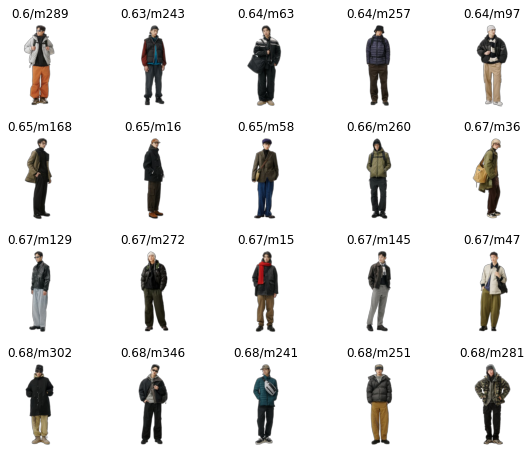

In [103]:
dists = np.linalg.norm(features - query, axis=1)

# 오름차순 정렬의 인덱스 어레이를 반환
ids = np.argsort(dists)[:20]

scores = [(dists[id], img_paths[id], id) for id in ids]

axes=[]
fig=plt.figure(figsize=(8,8))
for a in range(5*4):
    score = scores[a]
    axes.append(fig.add_subplot(5, 5, a+1))
    subplot_title=str(round(score[0],2)) + "/m" + str(score[2]+1)
    axes[-1].set_title(subplot_title)  
    plt.axis('off')
    plt.imshow(Image.open(score[1]))
fig.tight_layout()
plt.show()